# Tarea 3

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann

Extraimos los datos del primer circuito en un dataframe

In [69]:
df=pd.read_table('circuito1.txt',header=0)

Graficamos

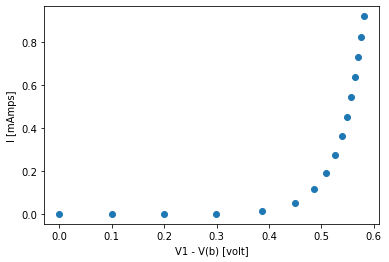

In [100]:
V = df['v1']-df['V(n002)']
I = df['I(D1)']
plt.plot(V, 1000*I, 'o')
plt.xlabel('V1 - V(b) [volt]')
plt.ylabel('I [mAmps]')
plt.show()

Definimos la funcion para realizar el ajuste: 

$$I(V) = a(e^{bV}-1)$$

En donde $a=I_0$ y $b = \frac{q}{KT}$

In [101]:
# Constantes:
K = Boltzmann
q = 1.602176634*(10**-19) # Coulomb

def corriente_I(V, a, b):
    return a*(np.exp(b*V)-1)

I_0 =  2.671286248137193e-09
T =  528.7231198337822


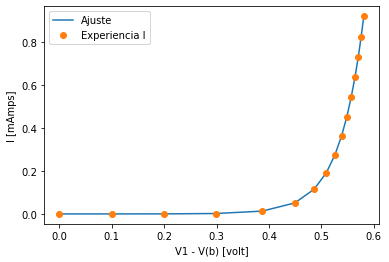

In [98]:
I_fit = curve_fit(corriente_I, V, I)
plt.plot(V, 1000*corriente_I(V, I_fit[0][0], I_fit[0][1]), label='Ajuste')
plt.plot(V, 1000*I, 'o' ,label='Experiencia I')
print('I_0 = ', I_fit[0][0] )
print('T = ', q/(K*I_fit[0][1]))
plt.xlabel('V1 - V(b) [volt]')
plt.ylabel('I [mAmps]')
plt.legend()
plt.show()